In [1]:
import numpy as np

In [12]:
class antonForest():

    def __init__(self, t_trees, sample_size, random_state) -> None:
        self.t_trees = t_trees
        self.sample_size = sample_size
        self.random_state = random_state

    def fit(self, X):
        
        self.forest = []
        height_limit = 8 #np.ceil(np.log2(self.sample_size)) #WARNING
        n_rows = X.shape[0]
        if n_rows < self.sample_size:
            self.sample_size = n_rows
        for i in range(self.t_trees):
            
            #index = self.random_state.choice(range(n_rows), size = self.sample_size, replace = False)
            #This row makes the subsampling and split values random for each run
            index = self.random_state.randint(0, n_rows, self.sample_size)
            #index = np.random.choice(range(n_rows), size=self.sample_size, replace=False)
            #index = np.random.randint(0, n_rows, self.sample_size)
            
            sub_X = X[index]
            
            tree = iTree(0, height_limit)
            tree.fit(sub_X)
            self.forest.append(tree)
            
        return self

    def path_length(self, data):

        edges = []

        for row in data:
            path = []
            for tree in self.forest:
                node = tree.root
                length = 0
                while isinstance(node, DecisionNode):
                    if row[node.q_value] < node.x_value:
                        node = node.left
                    else:
                        node = node.right
                    length += 1
                leaf_size = node.size
                path_length = length + c(leaf_size)
                path.append(path_length)
            
            edges.append(path)
        edges = np.array(edges)
        return np.mean(edges, axis = -1)

    def decision_function(self, data):

        average_length = self.path_length(data)
        scores = np.array([np.power(2, -l/c(self.sample_size)) for l in average_length])
        scores = 0.5 - scores
        return scores

    def predict_from_score(self, scores, threshold):
        return np.array([1 if s >= threshold else 0 for s in scores])

    def predict(self, data, threshold):
        scores = self.decision_function(data)
        prediction = self.predict_from_score(scores, threshold)
        return prediction

In [13]:
class Leaf:

    def __init__(self, size, data) -> None:
        self.size = size
        self.data = data

In [14]:
class DecisionNode:

    def __init__(self, left, right, q_value, x_value) -> None:
        self.left = left
        self.right = right
        self.q_value = q_value
        self.x_value = x_value

In [15]:
class iTree():

    def __init__(self, current_height, height_limit) -> None:
        self.current_height = current_height
        self.heigh_limit = height_limit

    def fit(self, sub_sample):
        
        X = sub_sample
        
        if self.current_height >= self.heigh_limit or X.shape[0] <= 1:
            self.root = Leaf(X.shape[0], X)
            return self.root
        else:
            #Chosing random q value
            n_attributes = X.shape[1]#WARNING changed from 1 to 0
            q_value = np.random.randint(0, n_attributes)
            #Chosing random x value
            x_value = np.random.uniform(min(X[:, q_value]), max(X[:, q_value]))

            X_left = X[X[:, q_value] < x_value]
            X_right = X[X[:, q_value] >= x_value]

            left_subtree = iTree(self.current_height + 1, self.heigh_limit)
            right_subtree = iTree(self.current_height + 1, self.heigh_limit)

            left_subtree.fit(X_left)
            right_subtree.fit(X_right)

            self.root = DecisionNode(left_subtree.root, right_subtree.root, q_value, x_value)
            #self.n_nodes = self.count_nodes(self.root)

            return self.root

    def count_nodes(self, root):
            
        count = 0
        stack = [root]
           
        while stack:
            node = stack.pop()
            count += 1

        if isinstance(node, DecisionNode):
            stack.append(node.right)
            stack.append(node.left)

        return count


Code for testing and running the classes and functions:

In [16]:
from __future__ import division
from __future__ import print_function
from sklearn.ensemble import IsolationForest

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from numpy import percentile
from sklearn.metrics import average_precision_score
import scipy.io
import matplotlib.pyplot as plt

In [17]:
# Define the number of inliers and outliers
n_samples = 256
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

In [18]:
random_state = np.random.RandomState(42)

In [2]:
# Fit the models with the generated data and 
# compare model performances
def c(size):
    #if size <= 1:
    #    return 1.
    #else:
    #    return 2. * (np.log(size-1.)+0.5772156649) - 2.*(size-1.)/size
    
    
    
    if size > 2:
        return 2 * (np.log(size-1)+0.5772156649) - 2*(size-1)/size
    if size == 2:
        return 1.
    return 0.

n_trees = 100
np.random.seed(42)
clf = antonForest(n_trees, 256, random_state=random_state)
clf_lib = IsolationForest(n_estimators = n_trees, random_state=random_state)
# Data generation
#X1 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offest
#X2 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offset
#X = np.r_[X1, X2]
# Add outliers
#X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

data = scipy.io.loadmat('C:\\Users\\anton\\OneDrive\\Skrivbord\\Thesis_Code\\IsolationForestTinyML\\DatSets\\ionosphere.mat',
                        squeeze_me=False)

enlist = list(data.items())
X = np.array(enlist, dtype=object)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 0)
X = np.delete(X, 0, 1)

y_true = np.empty([1,0], dtype=int)

#print(X[1][0][0])
k = 0
#while k < len(X[1][0]):
#    y_true = np.append(y_true, int(X[1][0][k]))
#    k += 1

X = X[0][0]
#print(X[0][0])
# Fit the model
#plt.figure(figsize=(15, 12))
# fit the data and tag outliers
p = 0
aps = []
aps_lib = []
outliers = 10
#while p < 10:
clf.fit(X)
clf_lib.fit(X)
#WARNING put +1
scores_pred = clf.decision_function(X) * 1
scores_pred_lib = clf_lib.decision_function(X) * 1 

threshold = percentile(scores_pred, 100 * outliers_fraction)
threshold_lib = percentile(scores_pred_lib, 100 * outliers_fraction)


#aps.append(average_precision_score(y_true, scores_pred))
#aps_lib.append(average_precision_score(y_true, scores_pred_lib))
#p += 1
#n_errors = (y_pred != ground_truth).sum()
# plot the levels lines and the points

#WARNING +1
#Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * 1
#Z = Z.reshape(xx.shape)
#plt.figure(figsize=[10,10])
#subplot = plt.subplot(2, 2, 1)
#subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
#                    cmap=plt.cm.Blues_r)
#a = subplot.contour(xx, yy, Z, levels=[threshold], #Removed - in front of threshold, since -score
#                    linewidths=2, colors='red')
#subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
#                    colors='orange')
#b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
#                    s=20, edgecolor='k')
#c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
#                    s=20, edgecolor='k')
#subplot.axis('tight')
#subplot.set_xlabel("%d. %s (errors: %d)" % (1, "Isolation Forest", n_errors))
#subplot.set_xlim((-7, 7))
#subplot.set_ylim((-7, 7))
#plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
#plt.suptitle("Outlier detection")
#plt.show()
#all_data = [aps, aps_lib]
#plt.boxplot(all_data)

å = 0
while(å < len(scores_pred)):
    print(scores_pred[å])
    å += 1

NameError: name 'np' is not defined

In [136]:

print(scores_pred_lib)

[ 0.01669184  0.00515473  0.05146643 -0.00547119 -0.00059348  0.03095742
 -0.00998812  0.05942021 -0.0349231  -0.00316742 -0.06395142  0.00918045
  0.05393689  0.0488285   0.04397609  0.04639708  0.07040348  0.00169034
  0.05296525  0.02083627 -0.0419589   0.03803893 -0.00221261  0.07508383
 -0.08267784  0.01710875  0.04180126  0.02780292  0.08832095  0.00675496
  0.04010822  0.03191191  0.09342941  0.05323876  0.08005986  0.05904484
  0.09137652  0.08382863  0.03752688  0.09494368  0.06112219  0.08445183
  0.07995298  0.08538066  0.05444135  0.05153005 -0.03015201  0.03459267
  0.08058774  0.02515008 -0.00078449  0.06544617  0.08105317  0.08829696
  0.08673784  0.08947275  0.02256765  0.0871629   0.0933216   0.06147927
  0.0580874  -0.03798971  0.07936059  0.03764077  0.06209469  0.07232379
  0.00376812  0.08115689  0.07910372  0.03761152  0.06531724  0.05629769
 -0.1236495   0.00887783 -0.0017858  -0.02653565  0.09099972  0.06039556
  0.02672626  0.06625448  0.0724465   0.05260476  0

(array([ 2.,  2.,  5.,  6., 10., 23., 21., 30., 15., 15.]),
 array([-0.06252613, -0.04745994, -0.03239375, -0.01732756, -0.00226138,
         0.01280481,  0.027871  ,  0.04293719,  0.05800338,  0.07306957,
         0.08813576]),
 <BarContainer object of 10 artists>)

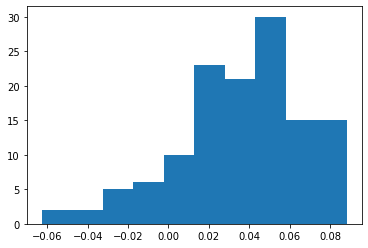

In [137]:
plt.hist(scores_pred)

(array([ 1.,  1.,  2.,  2.,  4., 12., 18., 17., 37., 35.]),
 array([-0.1236495 , -0.10179019, -0.07993087, -0.05807155, -0.03621223,
        -0.01435291,  0.00750641,  0.02936572,  0.05122504,  0.07308436,
         0.09494368]),
 <BarContainer object of 10 artists>)

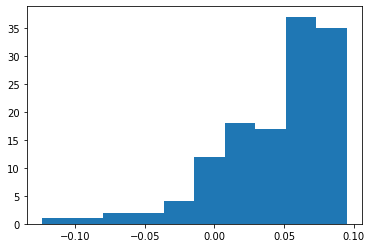

In [138]:
plt.hist(scores_pred_lib)

In [125]:
file = open("save_forest.ino", "w")

file.write("#include <vector>\n")
file.write("using namespace std;\n\n")
file.write("struct Tree{\n")
file.write("    int child_id_left, child_id_right, feature, n_samples;\n")
file.write("    float threshold;\n")
file.write("};\n\n")

file.write("vector<vector<Tree>> iForest;\n")
m = 0
while m < clf_lib.n_estimators:
    file.write("std::vector<Tree> iTree" + str(m + 1) + ";\n")
    m += 1
file.write("\n")

f = 0
file.write("void setup() {\n")
file.write("    Serial.begin(9600);\n")
while f < clf_lib.n_estimators:
    j = 0
    while j < len(clf_lib.estimators_[f].tree_.feature):
        temp_child_l = clf_lib.estimators_[f].tree_.children_left[j]
        if clf_lib.estimators_[f].tree_.children_left[j] == -1:
            temp_child_l = 0

        temp_child_r = clf_lib.estimators_[f].tree_.children_right[j]
        if temp_child_r == clf_lib.estimators_[f].tree_.children_right[j] == -1:
            temp_child_r = 0

        temp_feature = clf_lib.estimators_[f].tree_.feature[j]
        temp_threshold = clf_lib.estimators_[f].tree_.threshold[j]
        temps_values = clf_lib.estimators_[f].tree_.n_node_samples[j]

        file.write("    iTree" + str(f + 1) + ".push_back({"  
                                                            + str(temp_child_l) + ", "
                                                            + str(temp_child_r) + ", "
                                                            + str(temp_feature) + ", "
                                                            + str(temps_values) + ", "
                                                            + str(temp_threshold) + 
                                                        "});\n")

        j += 1

    file.write("    iForest.push_back(iTree" + str(f + 1) + ");\n\n")
    f += 1

rows = f*j
memory_per_vector = 8
allocated_memory = rows * memory_per_vector
file.write("}\n")
file.write("void loop() {\n")
file.write("\n}")




2

<Figure size 1080x864 with 0 Axes>

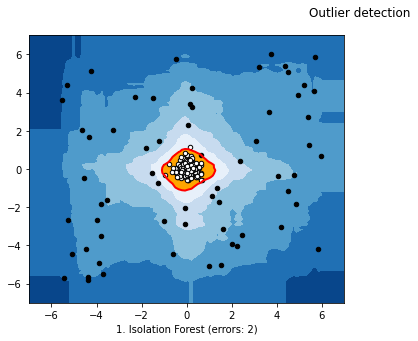

In [139]:
# Fit the models with the generated data and 
# compare model performances
def c(size):
    if size <= 1:
        return 1
    else:
        return 2. * (np.log(size-1.)+0.5772156649) - 2.*(size-1.)/size

np.random.seed(42)
clf = antonForest(100, 256, random_state=random_state)
clf_lib = IsolationForest(random_state=random_state)
# Data generation
X1 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offest
X2 = 0.3 * np.random.randn(n_inliers // 2, 2) #Removed offset
X = np.r_[X1, X2]
# Add outliers
X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]


# Fit the model
plt.figure(figsize=(15, 12))
# fit the data and tag outliers
clf.fit(X)
clf_lib.fit(X)
#WARNING put +1
scores_pred = clf.decision_function(X) * 1
scores_pred_lib = clf_lib.decision_function(X) * 1 

threshold = percentile(scores_pred, 100 * outliers_fraction)
threshold_lib = percentile(scores_pred_lib, 100 * outliers_fraction)

y_pred = clf.predict(X, threshold) * -1
y_pred = (y_pred + 1) #/ 2

y_pred_lib = clf_lib.predict(X) * -1
y_pred_lib = (y_pred_lib + 1) / 2

n_errors = (y_pred != ground_truth).sum()
# plot the levels lines and the points

#WARNING +1
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * 1
Z = Z.reshape(xx.shape)
plt.figure(figsize=[10,10])
subplot = plt.subplot(2, 2, 1)
subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                    cmap=plt.cm.Blues_r)
a = subplot.contour(xx, yy, Z, levels=[threshold], #Removed - in front of threshold, since -score
                    linewidths=2, colors='red')
subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                    colors='orange')
b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                    s=20, edgecolor='k')
c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                    s=20, edgecolor='k')
subplot.axis('tight')
subplot.set_xlabel("%d. %s (errors: %d)" % (1, "Isolation Forest", n_errors))
subplot.set_xlim((-7, 7))
subplot.set_ylim((-7, 7))
plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
plt.suptitle("Outlier detection")
plt.show()

In [140]:
print(scores_pred)

[ 0.16280269  0.13204607  0.16977461  0.1360178   0.16104879  0.16560154
  0.12442904  0.12959913  0.15334063  0.13955119  0.14054806  0.14642001
  0.16634536  0.14881356  0.16705213  0.12305806  0.15617496  0.13984554
  0.12093084  0.14211579  0.16041967  0.16820808  0.13789815  0.14571358
  0.13081358  0.16430417  0.15736123  0.14621318  0.1670545   0.15183273
  0.16707095  0.14191136  0.13313918  0.15359281  0.16315951  0.13781979
  0.13698496  0.08369043  0.16901318  0.12343542  0.16533199  0.13831063
  0.16403006  0.15049281  0.15945517  0.15862744  0.16500549  0.14521501
  0.16026244  0.17012355  0.14382557  0.16266801  0.16377949  0.12281993
  0.16611317  0.12657864  0.11425487  0.16516517  0.15439845  0.14493752
  0.15325228  0.12103754  0.11490291  0.15548909  0.16806163  0.13544239
  0.15112449  0.12296638  0.16586272  0.14107278  0.13957777  0.13533802
  0.15843566  0.13399636  0.15800312  0.1604331   0.16124132  0.16287897
  0.12273799  0.14575692  0.15047935  0.1453417   0

(array([  5.,  24.,  21.,   6.,   6.,   1.,   2.,   5.,  40., 146.]),
 array([-0.14862836, -0.11675317, -0.08487798, -0.05300279, -0.0211276 ,
         0.0107476 ,  0.04262279,  0.07449798,  0.10637317,  0.13824836,
         0.17012355]),
 <BarContainer object of 10 artists>)

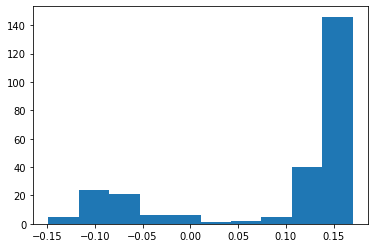

In [141]:
plt.hist(scores_pred)

(array([  7.,   8.,  23.,  12.,   8.,   5.,   0.,   6.,  29., 158.]),
 array([-0.19174075, -0.1557485 , -0.11975626, -0.08376401, -0.04777176,
        -0.01177952,  0.02421273,  0.06020498,  0.09619722,  0.13218947,
         0.16818172]),
 <BarContainer object of 10 artists>)

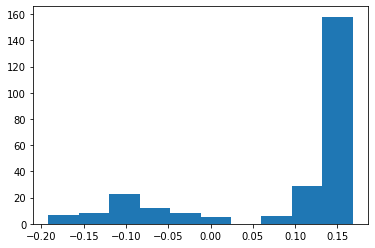

In [142]:
plt.hist(scores_pred_lib)